# Transfer Learning for Computer Vision Tutorial

**Created On**: Mar 24, 2017

**Last Updated**: Aug 27, 2024

**Last Verified**: Nov 05, 2024

Author: [Sasank Chilamkurthy](https://github.com/chilamkurthy)

在這個教學中，您將學習如何使用 PyTorch 進行影像分類的 Transfer Learning。

## 0. 環境準備

請先確認您的 Python 環境已安裝以下套件：

- `torch` (PyTorch)
- `torchvision`
- `matplotlib`
- `PIL` (通常隨 Python 安裝)

接著，確保以下目錄結構存在於工作目錄下：
```
data/hymenoptera_data
├── train
│   ├── ants
│   └── bees
└── val
    ├── ants
    └── bees
```
並放入對應的影像檔案（可從官方給定的下載連結取得）。

In [4]:
# 1. 引入必要套件
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from PIL import Image
from tempfile import TemporaryDirectory

# 為了加速卷積運算
cudnn.benchmark = True

# 使用互動模式顯示圖片
plt.ion()

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


## 2. 載入資料

使用 `ImageFolder` 讀取資料夾結構，並使用預先定義好的 transforms 進行資料增強或正規化：

In [5]:
# 2. 資料前處理與讀取

# 資料增強與正規化設定
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 根據您的資料夾路徑設置
data_dir = 'hymenoptera_data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# 使用 GPU (CUDA) 或 CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Data loaded!")
print("Train dataset size:", dataset_sizes['train'])
print("Val dataset size:\t", dataset_sizes['val'])
print("Classes:", class_names)

Data loaded!
Train dataset size: 244
Val dataset size:	 153
Classes: ['ants', 'bees']


## 3. 視覺化部分訓練資料
隨機取一個 batch，組成 grid 後繪製：

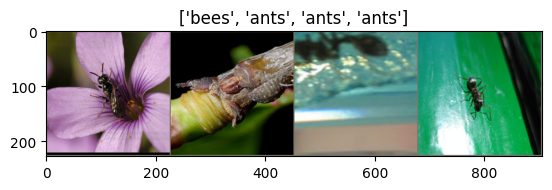

訓練集 batch 中對應的 label: ['bees', 'ants', 'ants', 'ants']


In [6]:
def imshow(inp, title=None):
    """顯示 Tensor 影像"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 取一個 batch
inputs, classes = next(iter(dataloaders['train']))
# 做成 grid
out = torchvision.utils.make_grid(inputs)
# 顯示影像
imshow(out, title=[class_names[x] for x in classes])
print("訓練集 batch 中對應的 label:", [class_names[x] for x in classes])

## 4. 定義訓練函式

- 可動態調整學習率（LR scheduler）。
- 在每個 epoch 的 validation 後，若表現提升就將該次模型權重暫存下來。
- 執行結束後載入表現最好的權重。

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # 建立暫存資料夾，用來存放最佳權重
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # 每個 epoch 皆進行 train 與 val
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                # 遍歷該 phase 中所有資料
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # 如果 validation 的表現進步，就儲存模型
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # 載入最佳權重
        model.load_state_dict(torch.load(best_model_params_path))
    return model

print("train_model function defined!")

train_model function defined!


## 5. 定義視覺化預測結果函式
在驗證集上隨機抓取一些影像，並顯示預測結果：

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

print("visualize_model function defined!")

visualize_model function defined!


## 6. Finetuning the ConvNet
此方式會重新訓練整個模型（包括 backbone），但最後一層輸出大小換成2類。

===== Finetuning the ConvNet =====
Epoch 0/24
----------
train Loss: 0.5360 Acc: 0.7582
val Loss: 0.2190 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4067 Acc: 0.8443
val Loss: 0.2594 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4024 Acc: 0.8156
val Loss: 0.7455 Acc: 0.7778

Epoch 3/24
----------
train Loss: 0.6021 Acc: 0.7828
val Loss: 0.3244 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.5146 Acc: 0.8033
val Loss: 0.2530 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4411 Acc: 0.8279
val Loss: 0.4908 Acc: 0.8366

Epoch 6/24
----------
train Loss: 0.8555 Acc: 0.7295
val Loss: 0.2431 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3106 Acc: 0.8893
val Loss: 0.2369 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3588 Acc: 0.8770
val Loss: 0.3352 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.2635 Acc: 0.8975
val Loss: 0.1963 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2815 Acc: 0.8893
val Loss: 0.2566 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3283 Acc: 0.87

C:\Users\eddyw\AppData\Local\Temp\ipykernel_26680\1022036207.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


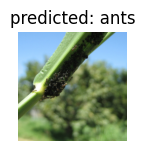

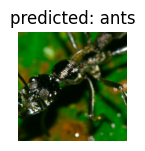

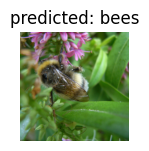

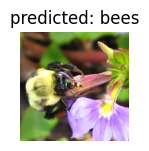

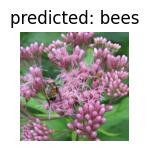

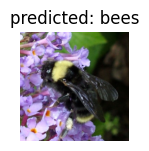

In [9]:
# 載入預訓練 ResNet18
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 新的全連接層，輸出 2 類
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

# 定義 Loss
criterion = nn.CrossEntropyLoss()

# 使用所有參數進行優化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每 7 個 epoch lr 衰減 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print("===== Finetuning the ConvNet =====")
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

# 視覺化預測
visualize_model(model_ft)
plt.show()

## 7. ConvNet as a fixed feature extractor
此方式會凍結絕大多數的權重，只更新最後一層參數：

===== ConvNet as fixed feature extractor =====
Epoch 0/24
----------
train Loss: 0.6295 Acc: 0.6885
val Loss: 0.2395 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4481 Acc: 0.7992
val Loss: 0.2698 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5632 Acc: 0.7541
val Loss: 0.2759 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3879 Acc: 0.8320
val Loss: 0.1942 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4831 Acc: 0.7951
val Loss: 0.1912 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.5353 Acc: 0.7828
val Loss: 0.3206 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.5034 Acc: 0.8033
val Loss: 0.2309 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3332 Acc: 0.8566
val Loss: 0.1704 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3621 Acc: 0.8320
val Loss: 0.1822 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3853 Acc: 0.8279
val Loss: 0.1810 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2804 Acc: 0.8730
val Loss: 0.1873 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.33

C:\Users\eddyw\AppData\Local\Temp\ipykernel_26680\1022036207.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


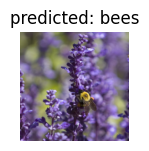

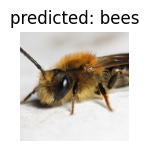

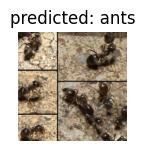

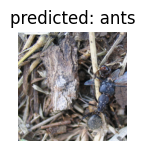

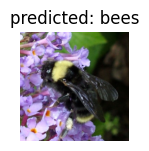

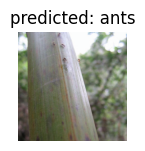

In [10]:
model_conv = models.resnet18(weights='IMAGENET1K_V1')
# 凍結所有參數
for param in model_conv.parameters():
    param.requires_grad = False

# 調整最後一層
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
# 只訓練最後一層
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print("===== ConvNet as fixed feature extractor =====")
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)
visualize_model(model_conv)
plt.show()

## 8. 在自訂圖上進行推論
可以將某張圖片丟進已訓練好的模型，看看預測結果：

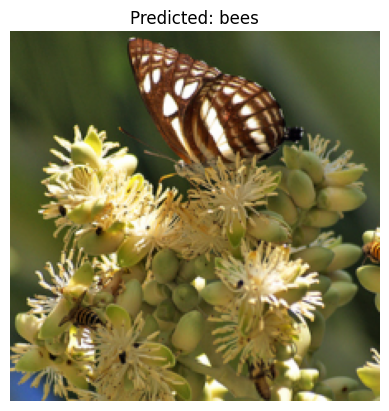

In [13]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    # 使用同樣的 val transform
    img = data_transforms['val'](img)
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(1,1,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

    plt.show()

# 測試範例，檔名可自行更改
img_path = 'hymenoptera_data/val/bees/72100438_73de9f17af.jpg'

# 若該路徑存在便可視覺化
if os.path.isfile(img_path):
    visualize_model_predictions(model_conv, img_path)
else:
    print(f"File not found: {img_path}")

## 9. 結語
整個 Transfer Learning 教學包含以下關鍵步驟：
1. 讀取資料並進行 Data Augmentation。
2. 使用預訓練的模型權重，視需求選擇 "微調所有層" 或 "僅凍結前幾層"。
3. 進行訓練與驗證，保存最佳權重。
4. 於推論階段可視覺化預測結果。

更多進階內容可參考 [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html) 或更多官方範例。

In [12]:
# 只為了顯示結束訊息
print("Tutorial execution finished.")

Tutorial execution finished.
